# <center>Movies Recommender System (on MovieLens 25M)</center>
Al giorno d'oggi un qualsiasi utente è inondato di scelte quando è in procinto di acquistare, visualizzare, nolleggiare contenuti di qualsiasi tipo. Capita di perdere molto tempo a navigare gli ormai infiniti cataloghi di piattaforme come Netflix, Spotify, Amazon con il fine di trovare qualcosa che soddisfi i propri gusti; e se anche dopo aver consultato non si è riusciti a trovare nulla di interessante, il cliente potrebbe perdere interesse nella piattaforma o addirittura abbandonarla.

Uno degli usi più comuni dei Big Data è proprio prevedere cosa, un insieme o un singolo utente, possa desiderare. 
É proprio avendo in mente questo scenario si cercherà di costruire un sistema di raccomandazione basato su Apache Spark che possa aiutare gli utenti nel trovare e scegliere dei film, migliorando la loro esperienza, creando coinvolgimento e generando più entrate per il provider del servizio.

Si inizierà con alcune tecniche di base costruendo un Popularity-Based Recommender System e successivamente, grazie all'utilizzo della libreria Spark ML, si cercherà di effettuare previsioni più sofisticate, personalizzate e mirate per ogni singolo utente.

Per questo caso di studio utilizzeremo i dati proveniente dal famoso dataset "MovieLens 25ml", il quale contiene 25 milioni di valutazioni (ratings). Il dataset completo è scaricabile dal seguente link: https://grouplens.org/datasets/movielens/25m/.

##### Configurazione Apache Spark

In [1]:
import findspark
findspark.init() # Inserire path Spark se non è presente tra le variabili d'ambiente

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import Row
from pyspark.sql.functions import *

In [2]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("MovieRecommenderSystem") \
    .config("spark.executor.memory", "16gb") \
    .config("spark.driver.memory", "16G") \
    .config("spark.driver.offHeap.enabled", "true") \
    .config("spark.driver.offHeap.size", "16G") \
    .config("spark.executor.maxResultSize", "16gb") \
    .getOrCreate()

In [3]:
# Controllo configurazione
# spark.sparkContext.getConf().getAll()

In [3]:
from pyspark.context import SparkContext
sc = spark.sparkContext
sc.setCheckpointDir(r'.\checkpoints')

### Datasets

Come detto in precedenza si è deciso di utilizzare MovieLens nella versione 25 milioni di ratings, dataset contenente dati a partire dal 9 gennaio 1995 fino al 21 novembre 2019.
Nella pagina ufficiale si può leggere che gli utenti inclusi nel dataset sono stati selezionati casualmente, con l'unico vincolo che avessero espresso un giudizio su almeno venti film differenti. Non sono presenti informazioni demografiche riguardanti gli utenti che sono rappresentati solo mediante un semplice ID.

Si può notare la presenza di ulteriori file csv che si è deciso di importare e utilizzare (movies.csv e links.csv) per ricavare ulteriori informazioni come titolo, genere o codici indenfiticativi per estrapolare e visualizzare le locandine dei film da siti del settore come https://www.themoviedb.org/ o https://www.imdb.com/.

In [4]:
ratings = spark.read.load(r".\ml-25m\ratings.csv", format="csv", sep=",", inferSchema="true", header="true")
links = spark.read.load(r".\ml-25m\links.csv", format="csv", sep=",", inferSchema="true", header="true")
movies = spark.read.load(r".\ml-25m\movies.csv", format="csv", sep=",", inferSchema="true", header="true")

In [6]:
ratings.show(5)
movies.show(5, truncate=False)
links.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
+------+-------+------+----------+
only showing top 5 rows

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II 

In [5]:
ratings.createOrReplaceTempView("ratings")
links.createOrReplaceTempView("links")
movies.createOrReplaceTempView("movies")

#### EDA (Exploratory Data Analysis)

In [8]:
import pandas as pd
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_style("whitegrid")
sns.set_palette("pastel")

In [9]:
print("Number of ratings:", ratings.count())
print("Number of users: ", ratings.select(countDistinct("userId")).first()[0])
print("Number of Movies: ", movies.count())

Number of ratings: 25000095
Number of users:  162541
Number of Movies:  62423


In [10]:
ratingCount = ratings.groupBy("rating").count().orderBy(col("count").desc())
ratings_count_pd = ratingCount.toPandas()

+------+-------+
|rating|  count|
+------+-------+
|   4.0|6639798|
|   3.0|4896928|
|   5.0|3612474|
|   3.5|3177318|
|   4.5|2200539|
|   2.0|1640868|
|   2.5|1262797|
|   1.0| 776815|
|   1.5| 399490|
|   0.5| 393068|
+------+-------+



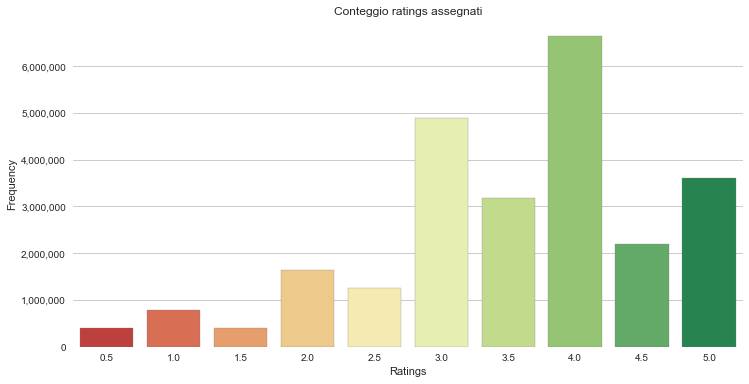

In [11]:
ratingCount.show()

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=ratings_count_pd, x="rating", y="count", palette="RdYlGn", edgecolor="grey", ax=ax)
ax.set_xlabel("Ratings")
ax.set_ylabel("Frequency")
ax.set_title("Conteggio ratings assegnati")

ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels(["{:,}".format(int(x)) for x in ticks_loc])

plt.show()

Come possiamo notare sia dalla figura che dalla tabella, i ratings dati con maggiore frequenza dagli utenti presenti nel dataset, sono valutazioni per lo più positive. Questa cosa non sorprende molto gli esperti del settore in quanto a livello psicologico un utente è più propenso a lasciare una valutazione quando il suo giudizio sull'item in questione è positivo. 

In [12]:
DFRatings_pd = ratings.toPandas() #conversione spark.Dataframe in pandas.Dataframe per facilità creazione grafici

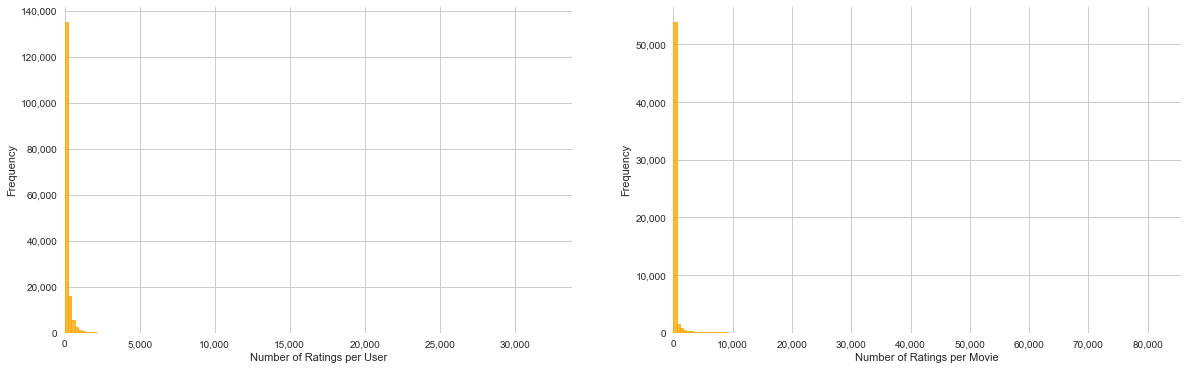

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
userRatingCount = DFRatings_pd.groupby("userId")['rating'].count() # userRatingGroup è una Series (index=userId,value=n_ratings)
userRatingCount.hist(bins=150, color="orange", edgecolor="orange",linewidth=1, alpha=0.78, ax=ax1)
ax1.set_xlabel("Number of Ratings per User")
ax1.set_ylabel("Frequency")
ax1.set_xlim(0.0)

ticks_loc = ax1.get_xticks().tolist()
ax1.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax1.set_xticklabels(['{:,}'.format(int(x)) for x in ticks_loc])

ticks_loc = ax1.get_yticks().tolist()
ax1.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ticks_loc])


movieRatingCount = DFRatings_pd.groupby("movieId")['rating'].count() # movieRatingGroup è Series(index=movieId,value=n_ratings)
movieRatingCount.hist(bins=150, color="orange", edgecolor="orange",linewidth=1, alpha=0.78, ax=ax2)
ax2.set_xlabel('Number of Ratings per Movie')
ax2.set_ylabel("Frequency")
ax2.set_xlim(0.0)

ticks_loc = ax2.get_xticks().tolist()
ax2.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax2.set_xticklabels(['{:,}'.format(int(x)) for x in ticks_loc])

ticks_loc = ax2.get_yticks().tolist()
ax2.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax2.set_yticklabels(['{:,}'.format(int(x)) for x in ticks_loc])

plt.show()

Quelli generati nello snippet precedente sono due grafici apparentemente simili ma con significato molto diverso: quello a sinistra ci mostra come un numero quasi insignificante di utenti esprime un numero elevatissimo di giudizi, mentre dal grafico a destra possiamo affermare che moltissimi film hanno un numero basso di ratings (long tail). 

In [14]:
print("L'utente con ID: {} ha votato {} volte".format(userRatingCount.idxmax(), userRatingCount.max()))
print("L'utente con ID: {} ha votato {} volte".format(userRatingCount.idxmin(), userRatingCount.min()))

L'utente con ID: 72315 ha votato 32202 volte
L'utente con ID: 51 ha votato 20 volte


In [15]:
print("Il film con ID: {} è stato votato {} volte".format(movieRatingCount.idxmax(), movieRatingCount.max())) #Forrest Gump
print("Il film con ID: {} è stato votato {} volte".format(movieRatingCount.idxmin(), movieRatingCount.min())) #Ratchet (1996)

Il film con ID: 356 è stato votato 81491 volte
Il film con ID: 1847 è stato votato 1 volte


##### Funzione ausiliaria per la visualizzazione delle locandine

Per una visualizzazione più accattivante delle raccomandazioni si sono utilizzate le API fornite da tmdb. Si è potuto fare ciò grazie alla presenza nel file links.csv degli identificativi univoci di ogni singolo film. Si è creata una funzione richiamabile ogni volta che oltre la classica visualizzazzione tabulare si desideri ricavare le locandine del film in questione. Le locandine visualizzate in output sono tutte cliccabili, si verrà reinderizzati alla relativa scheda in modo tale da ottenere ulteriori informazioni.

In [16]:
from tmdbv3api import TMDb
from IPython.core.display import display, HTML

tmdb = TMDb()
tmdb.language = 'it'

tmdb.api_key = '9bf92fa8dc6f2cba2c9581d4298d29ed'
from tmdbv3api import Movie

In [17]:
def stampaLocandine(movieList):
    movieApi=Movie()
    html='<table><tr>'
    i=0
    for film in movieList:
        # html+='<th><div>'+ p.title +'</div>'
        try:
            movie = movieApi.details(film.tmdbId)
            html+='<th>'
            html+='<a href="https://www.themoviedb.org/movie/'+ str(movie.id) +'" title="'+ str(movie.title) +'" target="_blank"><img src="https://image.tmdb.org/t/p/w200'+str(movie.poster_path)+'"></a></th>'
        except:
            html+='<th>'
            html+='<h3 style="text-align: center">'+ str(film.title) +'</h3><br><div style="text-align: center">(risorsa non trovata)</div></th>'
        i+=1
        if i==5:
            html+='</tr><tr>'
            i=0
    html+='</tr></table>'
    display(HTML(html))

## Popularity-Based Recommendation System

Il più semplice Recommender System che si possa costruire avendo a disposizione le valutazioni degli utenti sui film da loro guardati è quello basato su popolarità. Questo sistema in letteratura rientra negli approcci non-personalizzati, chiamati così in quanto suggeriscono a qualsiasi utente lo stesso identico output. Sistemi di questo genere sono per esempio "Guida Michelin", "Top 10 acquistati del mese" in Feltrinelli o Mondadori Store, ecc. Sono suggerimenti che possono essere definiti di tipo editoriale.

Un Recommender System di tipo non personalizzato basato su popolarità può essere implementato seguendo due approcci:
- Top Popular: il concetto di popolarità è legato al numero di ratings espressi, indipendentemente che essi siano positivi o negativi;
- Best Rated: in questo caso, invece, per ogni item si calcola la media dei ratings ricevuti e si scelgono quelli con media voti più alta.

### Top Popular

In [18]:
top_popular = ratings.groupBy("movieId").agg(countDistinct("userId"))\
              .withColumnRenamed("count(userId)", "Count_votes")\
              .join(movies.select(["movieId","title"]),"movieId")\
              .join(links.select(["movieId","tmdbId","imdbId"]),"movieId")\
              .orderBy(col("Count_votes").desc_nulls_last())

In [19]:
top_popular.show(10, truncate=False)

+-------+-----------+-----------------------------------------+------+------+
|movieId|Count_votes|title                                    |tmdbId|imdbId|
+-------+-----------+-----------------------------------------+------+------+
|356    |81491      |Forrest Gump (1994)                      |13    |109830|
|318    |81482      |Shawshank Redemption, The (1994)         |278   |111161|
|296    |79672      |Pulp Fiction (1994)                      |680   |110912|
|593    |74127      |Silence of the Lambs, The (1991)         |274   |102926|
|2571   |72674      |Matrix, The (1999)                       |603   |133093|
|260    |68717      |Star Wars: Episode IV - A New Hope (1977)|11    |76759 |
|480    |64144      |Jurassic Park (1993)                     |329   |107290|
|527    |60411      |Schindler's List (1993)                  |424   |108052|
|110    |59184      |Braveheart (1995)                        |197   |112573|
|2959   |58773      |Fight Club (1999)                        |5

In [20]:
stampaLocandine(top_popular.limit(10).rdd.collect())

,,,,
,,,,


### Best Rated

### Best Rated con semplice media voti

In [20]:
best_rated = ratings.groupBy("movieId").agg(countDistinct("userId"), avg("rating"))\
    .withColumnRenamed("count(userId)", "Count_votes")\
    .withColumnRenamed("avg(rating)", "Avg_votes")\
    .filter(col("Count_votes")>=500)\
    .join(movies.select(["movieId","title"]),"movieId")\
    .join(links.select(["movieId","tmdbId","imdbId"]),"movieId")\
    .orderBy(col("Avg_votes").desc_nulls_last())

In [21]:
best_rated_collect = best_rated.limit(10).rdd.collect()

In [22]:
stampaLocandine(best_rated_collect)

Planet Earth II (2016)(risorsa non trovata),Planet Earth (2006)(risorsa non trovata),,Band of Brothers (2001)(risorsa non trovata),
Blue Planet II (2017)(risorsa non trovata),,,Over the Garden Wall (2013)(risorsa non trovata),


### Best Rated con penalità sul numero di ratings

Si è prima effettuato un suggerimento dei film basandosi sulla semplice media aritmetica dei ratings. Si è però osservata la presenza di titoli che si è ritenuti effettivamente non rilevanti nonostante l'alta media dei ratings. Questo è dovuto al fatto che la media aritmetica non tiene conto del supporto su cui essa è calcolata.

Per ovviare a questo problema si è deciso di applicare un fattore di penalizzazzione logaritmico della frequenza sulla media dei ratings.

In [23]:
best_rated_logpenalty = ratings.groupBy("movieId").agg(countDistinct("userId"), avg("rating"), log(countDistinct("userId"))*avg("rating"))\
    .withColumnRenamed("count(userId)", "Count_votes")\
    .withColumnRenamed("avg(rating)", "Avg_votes")\
    .withColumnRenamed("(ln(count(userId)) * avg(rating))", "Inverse_freq_rating")\
    .join(links.select(["movieId","tmdbId","imdbId"]),"movieId")\
    .orderBy(col("Inverse_freq_rating").desc_nulls_last())

In [24]:
best_rated_logpenalty_collect = best_rated_logpenalty.limit(10).rdd.collect()

In [25]:
stampaLocandine(best_rated_logpenalty_collect)

,,,,
,,,,


Come si può osservare l'ultima lista di suggerimento fornita rispecchia molto meglio il concetto di popolarità.

### Popularity Based basato su categoria

Si è voluto sfruttare l'attributo "genres" presente nel dataset dei film per effettuare una ricerca degli item più popolari data in input una categoria tra tutte quelle presenti nel dataset.

In [26]:
movies_new = movies.select(col("movieId"), col("title"), explode(split(col("genres"),"\|")).alias("genres"))
test = movies_new.select('genres').distinct().collect()
genre_list = list()
for row in test:
    genre_list.append(row[0])
print(genre_list)

['Crime', 'Romance', 'Thriller', 'Adventure', 'Drama', 'War', 'Documentary', 'Fantasy', 'Mystery', 'Musical', 'Animation', 'Film-Noir', '(no genres listed)', 'IMAX', 'Horror', 'Western', 'Comedy', 'Children', 'Action', 'Sci-Fi']


In [27]:
def pop_rec_by_genere(genere):
    popular_inverse_genre = ratings.groupBy("movieId").agg(countDistinct("userId"), avg("rating"), log(countDistinct("userId"))*avg("rating"))\
        .withColumnRenamed("count(userId)", "Count_votes")\
        .withColumnRenamed("avg(rating)", "Avg_votes")\
        .withColumnRenamed("(ln(count(userId)) * avg(rating))", "Inverse_freq_rating")\
        .join(links.select(["movieId","tmdbId","imdbId"]), "movieId")\
        .join(movies.select(["movieId","genres","title"]), "movieId")\
        .filter(col("genres").like(genere))\
        .orderBy(col("Inverse_freq_rating").desc_nulls_last())
    popular_inverse_genre_collect = popular_inverse_genre.limit(10).rdd.collect();
    stampaLocandine(popular_inverse_genre_collect)

Nell'esempio seguente si è ottenuta una lista di film più famosi dato il genere **Horror**:

In [28]:
pop_rec_by_genere(genre_list[14]) #14 = Horror

,,,,
,,,,


## Collaborative Filtering Recommender System
Per collaborative filtering si intende una classe di strumenti e meccanismi di tipo personalizzato che consentono il recupero di informazioni predittive relativamente agli interessi di un insieme dato di utenti a partire da una massa ampia di conoscenza.

L'assunzione fondamentale dietro il concetto di collaborative filtering è che ogni singolo utente che ha mostrato un certo insieme di preferenze continuerà a mostrarle in futuro. Da notare che, sebbene tali informazioni siano referenti a un singolo utente, esse derivano dalla conoscenza elaborata su tutto l'arco dell'insieme degli utenti del sistema.

Una categoria molto nota di algoritmi di tipo collaborativo è la matrix factorization.

### ALS (Alternating Least Squares)
L'algoritmo implementato nella libreria MLlib di Apache Spark per fornire raccomandazioni di tipo collaborativo è l'Alternating Least Squares, un algoritmo di fattorizzazione di matrice (Matrix Factorization algorithm) per il calcolo distribuito e parallelo.

Questo algoritmo risolve i problemi che emergono dalla gestione di matrici sparse, molto comuni nel campo dei sistemi di raccomandazione in cui i dataset hanno spesso parecchi valori mancanti.

Inoltre, ALS minimizza poi due loss function alternativamente:

- Prima, blocca la matrice user e usa la Discesa del Gradiente sulla quella item
- Poi, blocca la matrice item e calcola la Discesa del Gradiente sulla matrice user

Quindi, l'ALS esegue l’algoritmo di Gradient Descent in parallelo su partizioni multiple del training set da un cluster di macchine connesse, risolvendo così anche i problemi di scalabilità.


In [6]:
(train, test) = ratings.randomSplit([0.8, 0.2], seed=8)

# Per ottimizzare la gestione della memoria si è adottato un approccio a checkpoint
# che ha risolto il problema di StackOverflowError durante i primi fitting del modello
train_ckpt = train.checkpoint(eager=True) 
test_ckpt = test.checkpoint(eager=True)

In [30]:
dim_train = train_ckpt.count()
dim_test = test_ckpt.count()
print("Rows in Training set: ", dim_train)
print("Rows in Test set: ", dim_test)

Rows in Training set:  19996875
Rows in Test set:  5003220


Così come ogni altro algoritmo di machine learning, anche l’ALS ha il suo set d’iperparametri da ottimizzare. Nel nostro caso, trattandosi di feedback espliciti (ratings), gli iperparametri di interesse sono:
- maxIter: il numero massimo d’iterazioni da eseguire (default a 10)
- rank: il numero di fattori latenti del modello (default a 10)
- regParam: il parametro di regolarizzazione per ALS (default a 1.0)

Per fare ciò si è usata una 5-fold Cross Validation avente come metrica di valutazione l'RMSE (Root Mean Square Error).

In [31]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")

als = ALS(userCol = "userId", itemCol = "movieId", ratingCol = "rating", coldStartStrategy = "drop")

# Abbiamo usato ParamGridBuilder per costruire una griglia di parametri.
# Con 2 valori per maxIter, 5 per regParam e 3 per rank,
# questa griglia avrà 2 x 5 x 3 = 30 possibili combinazioni tra cui scegliere il miglior modello.
paramGrid = ParamGridBuilder() \
            .addGrid(als.maxIter, [15, 20]) \
            .addGrid(als.regParam, [0.05, 0.1, 0.2, 0.4, 0.8]) \
            .addGrid(als.rank, [10, 11, 12]) \
            .build()

crossvalidation = CrossValidator(estimator = als,
                                 estimatorParamMaps = paramGrid,
                                 evaluator = evaluator,
                                 numFolds = 5)

In [32]:
cv_model = crossvalidation.fit(train_ckpt)

In [33]:
best_model = cv_model.bestModel

In [34]:
predictions = best_model.transform(test_ckpt)

In [35]:
predictions.show(5)
rmse_test = evaluator.evaluate(predictions)
print("RMSE (Test Set): ",rmse_test)

+------+-------+------+---------+----------+
|userId|movieId|rating|timestamp|prediction|
+------+-------+------+---------+----------+
| 26480|    148|   2.0|915406133| 1.8977656|
| 21531|    148|   3.0|834035555| 3.0807085|
| 77130|    148|   1.0|831284829| 0.6668097|
| 28229|    148|   1.0|833850593| 3.1786423|
| 64112|    148|   3.0|940520793| 3.1744792|
+------+-------+------+---------+----------+
only showing top 5 rows

RMSE (Test Set):  0.782146149464916


### ALS con parametri di default
Nella seguente sezione si è voluto eseguire l'algoritmo ALS (con i valori di default degli iperparametri), naturalmente utilizzando lo stesso insieme di training su cui è stato eseguito utilizzando la Cross Validation.

In [81]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
evaluator = RegressionEvaluator(metricName = "rmse", labelCol = "rating", predictionCol = "prediction")

als_default = ALS(maxIter=10, regParam=1, rank=10, userCol="userId", itemCol="movieId", ratingCol="rating",coldStartStrategy="drop")
model_default = als_default.fit(train_ckpt)

predictions_default = model_default.transform(test_ckpt)
rmse_test_als_default = evaluator.evaluate(predictions_default)
print("RMSE (Test Set) con ALS_default: ", rmse_test_als_default)

RMSE (Test Set) con ALS_default:  1.3219202581351595


Come possiamo osservare, il valore dell'RMSE valutato sullo stesso test set è maggiore quando si utilizza l'algoritmo ALS con i valori di default (1,3219) rispetto all'utilizzo del best model ricavato dalla Cross Validation (0.7821). Come possiamo notare dallo snippet successivo, i valori degli iperparametri del miglior modello sono molto lontati da quelli di dafault...le 4 ore e mezza rihiesta dall'operazione fit hanno portato alla costruzione di un miglior modello.

#### Info Best Model

In [37]:
print('Parametri Best Model:')
print("Rank:", best_model.rank)
print("Max Iter:", best_model._java_obj.parent().getMaxIter())
print("Reg Param:", best_model._java_obj.parent().getRegParam())

Parametri Best Model:
Rank: 12
Max Iter: 20
Reg Param: 0.05


#### Training e Test RMSE su CV-Model e Baseline-Model

In [83]:
predictions_train_als_cv = best_model.transform(train_ckpt)
rmse_train_als_cv = evaluator.evaluate(predictions_train_als_cv)
print("Training RMSE best model: ", rmse_train_als_cv)

predictions_train_als_default = model_default.transform(train_ckpt)
rmse_train_als_default = evaluator.evaluate(predictions_train_als_default)
print("Training RMSE default model: ", rmse_train_als_default)

Training RMSE best model:  0.7193885708677163
Training RMSE default model:  1.316682799330212


In [84]:
# Dataframe con RMSE modelli
df_rmse = pd.DataFrame({ "model" : ["5-Fold Cross Validated ALS model", "Baseline ALS Model"],
                    "Training RMSE" : [rmse_train_als_cv, rmse_train_als_default],
                    "Test RMSE" : [rmse_test, rmse_test_als_default]}).set_index("model")
print(df_rmse)

                                  Training RMSE  Test RMSE
model                                                     
5-Fold Cross Validated ALS model       0.719389   0.782146
Baseline ALS Model                     1.316683   1.321919


#### Salvataggio e caricamento del modello addestrato

In [38]:
# Per evitare di rieseguire il fitting del modello, si è deciso di salvarlo per poi ricaricarlo quando necessario.
# Il tempo di elaborazione è stato di circa 4h 30m.
cv_model.write().overwrite().save(r'.\model')

In [8]:
# Istruzione per il caricamento del modello già fittato.
from pyspark.ml.tuning import CrossValidatorModel
model_imp = CrossValidatorModel.load(r'.\model')
best_model = model_imp.bestModel

### Generazione liste suggerimenti

In [40]:
# Generazione lista top 10 per ogni utente
userRecs = best_model.recommendForAllUsers(10)

# Generazione lista utenti per ogni film
movieRecs = best_model.recommendForAllItems(10)

userRecs.show(5)
movieRecs.show(5)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[{200930, 5.58232...|
|   463|[{163921, 7.83578...|
|   471|[{200930, 5.61941...|
|   496|[{171429, 6.74089...|
|   833|[{192089, 4.95588...|
+------+--------------------+
only showing top 5 rows

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    148|[{18507, 5.387201...|
|    463|[{18885, 5.976638...|
|    471|[{86599, 5.551526...|
|    496|[{18885, 5.967755...|
|    833|[{127483, 6.08745...|
+-------+--------------------+
only showing top 5 rows



Come abbiamo potuto osservare, molto spesso non è necessario calcolare le predizioni dei ratings per tutti gli utenti in merito a tutti gli item. Per questo si è effettuato la raccomandazione prima per un dato utente (dato l'userID) e successivamente indicato un film (movieId) si è ricavata la lista degli utenti più indicati a cui effettuare la raccomandazione del film selezionato.

### Suggerimenti film dato un userID in input

In [41]:
user_id = 444
user = ratings.select(als.getUserCol()).distinct().filter(col("userId")==user_id)

In [42]:
userSubsetRecs = best_model.recommendForUserSubset(user, 10)
userSubsetRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   444|[{157997, 5.74504...|
+------+--------------------+



In [43]:
recdf = userSubsetRecs.select("userId",explode("recommendations"))

In [44]:
result_movie = recdf.withColumn('movieId', recdf.col.movieId)\
    .withColumn('rating', recdf.col.rating)\
    .drop("col")

In [45]:
result_movie = result_movie.join(movies.select(["movieId", "title"]), "movieId").join(links.select(["tmdbId", "movieId"]), "movieId")

In [46]:
result_movie.show(truncate = False)

+-------+------+---------+---------------------------------------------------------------------------+------+
|movieId|userId|rating   |title                                                                      |tmdbId|
+-------+------+---------+---------------------------------------------------------------------------+------+
|157997 |444   |5.7450433|Tintin and the Lake of Sharks (1972)                                       |241004|
|203086 |444   |5.660636 |Truth and Justice (2019)                                                   |583841|
|155113 |444   |5.5587997|Motherland (2015)                                                          |363846|
|116847 |444   |5.459465 |United States of Secrets (Part One): The Program (2014)                    |273334|
|189157 |444   |5.440115 |Born in the USSR: 7 Up (1991)                                              |182660|
|159107 |444   |5.4312534|Bill Hicks: Totally Bill Hicks (1994)                                      |23802 |
|141880 |4

In [47]:
stampaLocandine(result_movie.rdd.collect())

,,,,
,,,,


### Lista utenti potenzialmente interessati dato un film in input

In [48]:
item_id = 260 #Guerre stellari
item = ratings.select(als.getItemCol()).distinct().filter(col("movieId")==item_id)

In [49]:
movieSubsetRecs = best_model.recommendForItemSubset(item, 10) #per brevità solo i top-10 utenti a cui consigliare il film
movieSubsetRecs.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|    260|[{75922, 6.563246...|
+-------+--------------------+



In [50]:
recdf_users = movieSubsetRecs.select("movieId",explode("recommendations"))

In [51]:
result_users = recdf_users.withColumn('userId', recdf_users.col.userId)\
    .withColumn('rating', recdf_users.col.rating)\
    .drop("col")

In [52]:
print("Il film {} è consigliabile agli utenti: ".format(movies.filter(col("movieId")==item_id).collect()[0]["title"]))
result_users.show(truncate=False)

Il film Star Wars: Episode IV - A New Hope (1977) è consigliabile agli utenti: 
+-------+------+---------+
|movieId|userId|rating   |
+-------+------+---------+
|260    |75922 |6.5632463|
|260    |136879|6.4799743|
|260    |145072|6.4615164|
|260    |155761|6.4225745|
|260    |36882 |6.316824 |
|260    |71902 |6.306372 |
|260    |75420 |6.269747 |
|260    |146993|6.16797  |
|260    |86713 |6.1625905|
|260    |59452 |6.1211576|
+-------+------+---------+



## Ulteriore valutazione modelli

Considerando una votazione maggiore di 3 come rilevante ed una minore come non rilevante sono stati prodotti i seguenti report in merito alla classificazione:

### Classification Report Best Model

In [10]:
pdrs = best_model.transform(test_ckpt)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|   1653|   4.0|1147868097|   3.44753|
|     1|   3569|   5.0|1147879603| 3.9360368|
|     1|   4308|   3.0|1147868534| 3.8243463|
|     1|   5269|   0.5|1147879571|   3.61861|
|     1|   5684|   2.0|1147879797|  3.669652|
+------+-------+------+----------+----------+
only showing top 5 rows



In [43]:
pdrs_mod = pdrs.withColumn("rating_class",when(col("rating") >= 3, "relevant").otherwise("non_relevant"))\
               .withColumn("pred_class",when(col("prediction") >= 3, "relevant").otherwise("non_relevant"))

In [45]:
pdrs_mod_pd = pdrs_mod.toPandas()

In [75]:
y_true = pdrs_mod_pd.rating_class
y_pred = pdrs_mod_pd.pred_class

In [74]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

non_relevant     0.5178    0.6716    0.5848    892642
    relevant     0.9237    0.8641    0.8929   4107665

    accuracy                         0.8297   5000307
   macro avg     0.7208    0.7679    0.7388   5000307
weighted avg     0.8513    0.8297    0.8379   5000307



### Classification Report Baseline Model

In [83]:
pdrs_mod_def = predictions_default.withColumn("rating_class",when(col("rating") >= 3, "relevant").otherwise("non_relevant"))\
               .withColumn("pred_class",when(col("prediction") >= 3, "relevant").otherwise("non_relevant"))

In [84]:
pdrs_mod_def_pd = pdrs_mod_def.toPandas()

In [85]:
y_true_def = pdrs_mod_def_pd.rating_class
y_pred_def = pdrs_mod_def_pd.pred_class

In [86]:
from sklearn.metrics import classification_report
print(classification_report(y_true_def, y_pred_def, digits=4))

              precision    recall  f1-score   support

non_relevant     0.2078    0.9746    0.3426    892642
    relevant     0.9722    0.1928    0.3218   4107665

    accuracy                         0.3324   5000307
   macro avg     0.5900    0.5837    0.3322   5000307
weighted avg     0.8358    0.3324    0.3255   5000307

